<a href="https://colab.research.google.com/github/simsekergun/RingDimensionDS/blob/main/Dimension_Prediction_from_Integrated_Dispersion_Data_SM1_200.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal of this project is to predict the dimensions of a ring (width and height) from the integrated dispersion datasets. The datasets can be found at https://github.com/simsekergun/RingDimensionDS/. In all datasets, the first two column are the dimensions (Y), and the following columns are the integrated dispersion values computed at 171 wavelengths ranging from 750 nm to 1600 nm.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

Let's get our datasets

In [2]:
XY_train = pd.read_csv('https://raw.githubusercontent.com/simsekergun/RingDimensionDS/refs/heads/main/datasets/SiNtrainingDint1SM1_200.csv', header=None)
XY_test = pd.read_csv('https://raw.githubusercontent.com/simsekergun/RingDimensionDS/refs/heads/main/datasets/SiNtestDint1SM1_200.csv', header=None)

In [3]:
XY_train.head(3)

,0,1,2,3,4,5,6,7,8,9,...,163,164,165,166,167,168,169,170,171,172
0,7.500000e-07,6.200000e-07,-1615.6,-1316.9,-1068.5,-832.51,-624.63,-432.27,-265.14,-112.62,...,-12617.0,-13262.0,-13554.0,-14070.0,-14371.0,-14831.0,-15598.0,-15910.0,-16300.0,-17114.0
1,7.600000e-07,6.200000e-07,-1666.5,-1370.9,-1089.4,-866.55,-637.16,-437.85,-266.29,-112.56,...,-11260.0,-11783.0,-12080.0,-12720.0,-12891.0,-13520.0,-13782.0,-14564.0,-14777.0,-15275.0
2,7.700000e-07,6.200000e-07,-1728.8,-1456.0,-1159.7,-910.87,-680.35,-477.72,-299.04,-141.13,...,-10239.0,-10453.0,-10859.0,-11135.0,-11816.0,-11909.0,-12406.0,-13098.0,-13369.0,-13941.0


In [4]:
X_train = XY_train.iloc[:,2::]
Y_train = XY_train.iloc[:,[0,1]]*1e9  # convert meters to nanometers

Y_test = XY_test.iloc[:,[0,1]]*1e9
X_test = XY_test.iloc[:,2::]

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(441, 171) (441, 2) (44, 171) (44, 2)


<b> Let's first try linear regression  </b>

In [5]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()         # Instantiate
reg.fit(X_train, Y_train)        # Fit the train data

r2_train_score = reg.score(X_train, Y_train)   # Calculating R^2 score for training
print('R^2 score for n-train dataset = ', round(r2_train_score, 4), '\n')

R^2 score for n-train dataset =  0.8926 



In [6]:
# let's define a function to plot truth vs prediction and report errors
def compare_results(y_actual, pred1, pred2):
  # Create a figure with 1 row and 2 columns of subplots
  plt.figure(figsize=(8, 4))  # Wider figure to accommodate side-by-side plots

  # First subplot (Widths)
  plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
  plt.plot([np.min(y_actual[:,0]), np.max(y_actual[:,0])],
          [np.min(y_actual[:,0]), np.max(y_actual[:,0])],
          color='r', linestyle='dashed')
  plt.plot(y_actual[:, 0], pred1, 'o')
  plt.title('Comparison of Actual and Predicted Widths')
  plt.xlabel('Actual')
  plt.ylabel('Prediction')
  plt.grid()

  # Second subplot (Heights)
  plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
  plt.plot([np.min(y_actual[:,1]), np.max(y_actual[:,1])],
          [np.min(y_actual[:,1]), np.max(y_actual[:,1])],
          color='r', linestyle='dashed')
  plt.plot(y_actual[:, 1], pred2, 'o')
  plt.title('Comparison of Actual and Predicted Heights')
  plt.xlabel('Actual')
  plt.ylabel('Prediction')
  plt.grid()

  # Adjust layout to prevent overlap
  plt.tight_layout()
  plt.show()

  # Calculate absolute errors for the first output variable
  absolute_errors = np.abs(y_actual[:, 0] - pred1)

  # 1. Absolute Error Metrics
  min_abs_error = np.min(absolute_errors)
  mean_abs_error = np.mean(absolute_errors)
  max_abs_error = np.max(absolute_errors)

  print("Absolute Error Metrics for Width:")
  print(f"Minimum Absolute Error (nm): {min_abs_error:.4f}")
  print(f"Mean Absolute Error (nm): {mean_abs_error:.4f}")
  print(f"Maximum Absolute Error (nm): {max_abs_error:.4f}")
  print()


  # Calculate absolute errors for the first output variable
  absolute_errors = np.abs(y_actual[:, 1] - pred2)

  # 1. Absolute Error Metrics
  min_abs_error = np.min(absolute_errors)
  mean_abs_error = np.mean(absolute_errors)
  max_abs_error = np.max(absolute_errors)

  print("Absolute Error Metrics for Height:")
  print(f"Minimum Absolute Error (nm): {min_abs_error:.4f}")
  print(f"Mean Absolute Error (nm): {mean_abs_error:.4f}")
  print(f"Maximum Absolute Error (nm): {max_abs_error:.4f}")
  print()

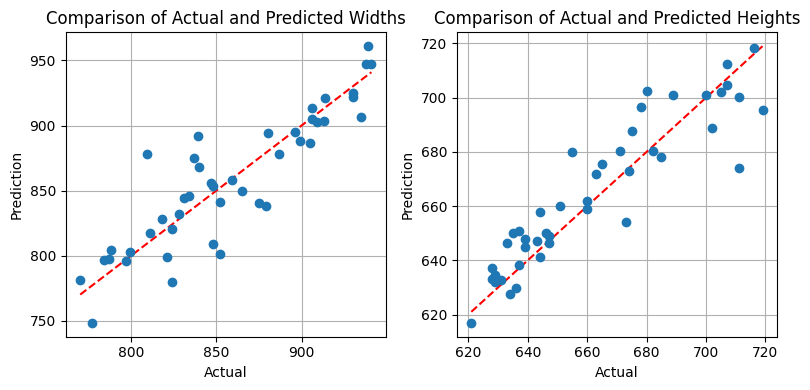

Absolute Error Metrics for Width:
Minimum Absolute Error (nm): 0.9352
Mean Absolute Error (nm): 17.2814
Maximum Absolute Error (nm): 69.1602

Absolute Error Metrics for Height:
Minimum Absolute Error (nm): 0.5355
Mean Absolute Error (nm): 8.7788
Maximum Absolute Error (nm): 36.9019



In [7]:
preds = reg.predict(X_test)
compare_results(Y_test.values, preds[:,0], preds[:,1])

<b> Now, let's build different neural networks and see which one performs the best</b>

In [8]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Add, Dense, LeakyReLU, Input, Multiply, Activation, Dropout, LayerNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [9]:
# Let's scale the datasets
xmax = 20000
column_means = Y_train.mean()
column_maxs = Y_train.max()
column_mins = Y_train.min()

y_actual = Y_test.values

X_train_scaled = X_train.values/xmax
X_test_scaled = X_test.values/xmax
Y_train_sc = (Y_train-column_means)/(column_maxs-column_means)
Y_test_sc = (Y_test-column_means)/(column_maxs-column_means)
Y_train_scaled = Y_train_sc.values
Y_test_scaled = Y_test_sc.values

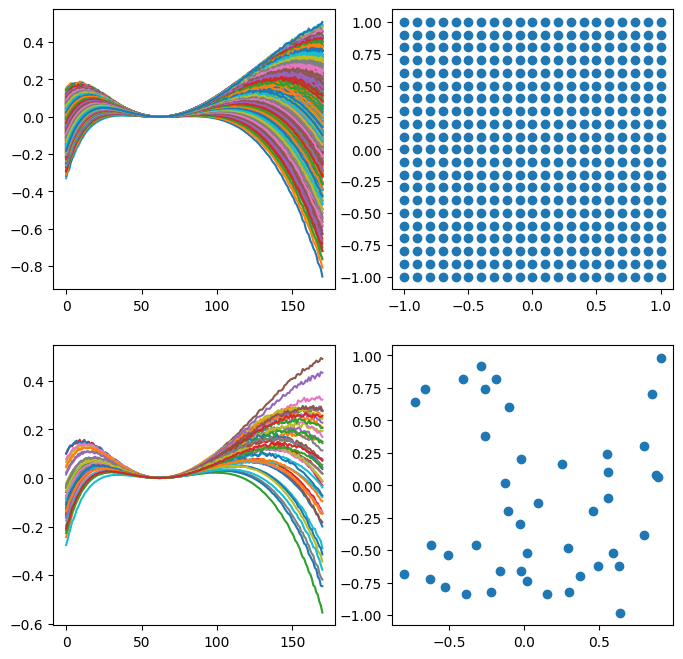

In [10]:
# Let's visaulize our scaled dataset
plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
plt.plot(X_train_scaled.T)

plt.subplot(2, 2, 2)
plt.plot(Y_train_scaled[:,0],Y_train_scaled[:,1],'o')

plt.subplot(2, 2, 3)
plt.plot(X_test_scaled.T)

plt.subplot(2, 2, 4)
plt.plot(Y_test_scaled[:,0],Y_test_scaled[:,1],'o')
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 38: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 43: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 48: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 53: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 58: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 63: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 68: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 72: early stopping
Restoring model weights from the end of the best epoch: 57.
Training MAE: 0.0786
Test MAE: 0.0136
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


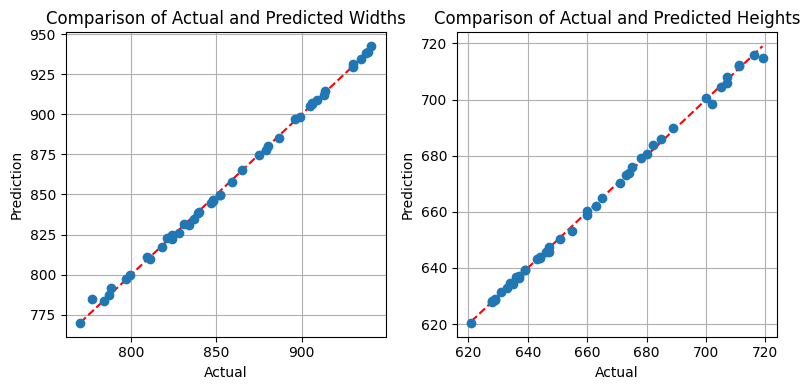

Absolute Error Metrics for Width:
Minimum Absolute Error (nm): 0.1031
Mean Absolute Error (nm): 1.2251
Maximum Absolute Error (nm): 7.7141

Absolute Error Metrics for Height:
Minimum Absolute Error (nm): 0.0142
Mean Absolute Error (nm): 0.7430
Maximum Absolute Error (nm): 4.1056



In [11]:
# Let's build our first neural network model
model = Sequential([
    Dense(128, input_shape=(171,)),
    LeakyReLU(0.5),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='linear')  # Output layer with 2 units for your 2 outputs
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mae'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(X_train_scaled, Y_train_scaled,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_test_scaled, Y_test_scaled),
                    callbacks=[reduce_lr, early_stop],
                    verbose=0)

# Evaluate the model
train_loss, train_mae = model.evaluate(X_train_scaled, Y_train_scaled, verbose=0)
test_loss, test_mae = model.evaluate(X_test_scaled, Y_test_scaled, verbose=0)

print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Predict on test data
y_pred_scaled = model.predict(X_test_scaled)

pred1 = y_pred_scaled[:,0]*(column_maxs[0]-column_means[0])+column_means[0]
pred2 = y_pred_scaled[:,1]*(column_maxs[1]-column_means[1])+column_means[1]

compare_results(y_actual, pred1, pred2)

Network 2

In [12]:
# Build model with regularization
model = Sequential([
    Dense(256, activation='relu', input_shape=(171,),
          kernel_regularizer=regularizers.l2(0.001)),
    Dense(128, activation='relu',
          kernel_regularizer=regularizers.l2(0.001)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='linear')
])

# Add callbacks
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5)
]

# Compile with lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='mse',
              metrics=['mae'])

# Train with more epochs
history = model.fit(X_train_scaled, Y_train_scaled,
                    epochs=300,
                    batch_size=32,
                    validation_data=(X_test_scaled, Y_test_scaled),
                    callbacks=callbacks,
                    verbose=0)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


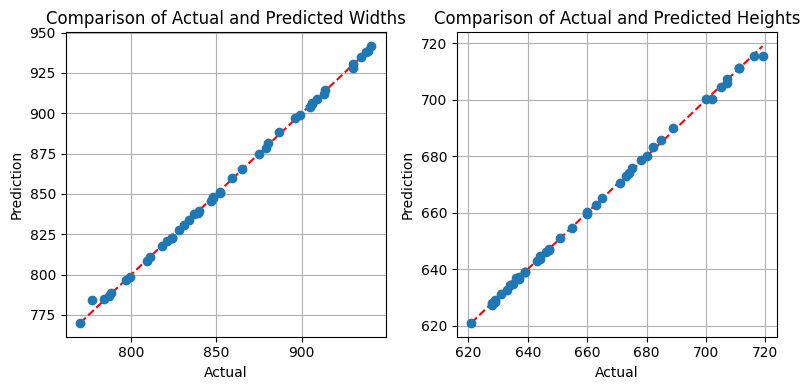

Absolute Error Metrics for Width:
Minimum Absolute Error (nm): 0.0139
Mean Absolute Error (nm): 0.7671
Maximum Absolute Error (nm): 7.2195

Absolute Error Metrics for Height:
Minimum Absolute Error (nm): 0.0145
Mean Absolute Error (nm): 0.4510
Maximum Absolute Error (nm): 3.3913



In [13]:
y_pred_scaled = model.predict(X_test_scaled)

pred1 = y_pred_scaled[:,0]*(column_maxs[0]-column_means[0])+column_means[0]
pred2 = y_pred_scaled[:,1]*(column_maxs[1]-column_means[1])+column_means[1]

compare_results(y_actual, pred1, pred2)

Network 3


Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0003499999875202775.

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.00017499999376013875.

Epoch 29: ReduceLROnPlateau reducing learning rate to 8.749999688006938e-05.

Epoch 34: ReduceLROnPlateau reducing learning rate to 4.374999844003469e-05.

Epoch 39: ReduceLROnPlateau reducing learning rate to 2.1874999220017344e-05.

Epoch 44: ReduceLROnPlateau reducing learning rate to 1.0937499610008672e-05.

Epoch 49: ReduceLROnPlateau reducing learning rate to 5.468749805004336e-06.

Epoch 54: ReduceLROnPlateau reducing learning rate to 2.734374902502168e-06.

Epoch 59: ReduceLROnPlateau reducing learning rate to 1.367187451251084e-06.

Epoch 64: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch: 300.


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


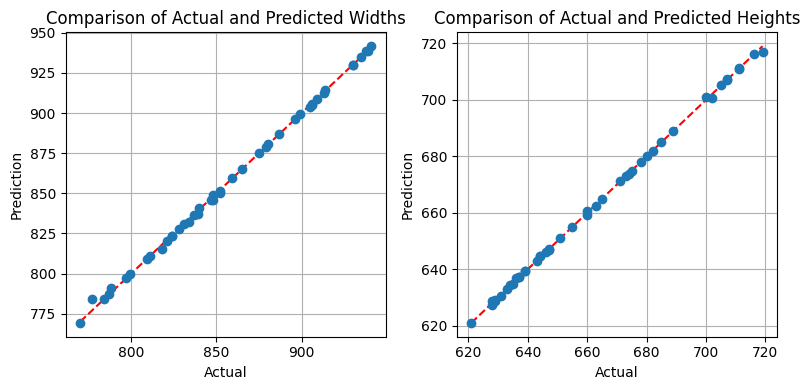

Absolute Error Metrics for Width:
Minimum Absolute Error (nm): 0.0047
Mean Absolute Error (nm): 0.8092
Maximum Absolute Error (nm): 6.9633

Absolute Error Metrics for Height:
Minimum Absolute Error (nm): 0.0069
Mean Absolute Error (nm): 0.3642
Maximum Absolute Error (nm): 1.9537



In [14]:
inputs = tf.keras.Input(shape=(171,))
x = Dense(128, activation='relu')(inputs)
residual = x

# Residual block 1
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Add()([x, residual])
residual = x

# Residual block 2
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Add()([x, residual])

outputs = Dense(2, activation='linear')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=0.0007),
              loss='mse',
              metrics=['mae'])
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(X_train_scaled, Y_train_scaled,
                    epochs=300,
                    batch_size=32,
                    validation_data=(X_test_scaled, Y_test_scaled),
                    callbacks=[reduce_lr, early_stop],
                    verbose=0)

y_pred_scaled = model.predict(X_test_scaled)

pred1 = y_pred_scaled[:,0]*(column_maxs[0]-column_means[0])+column_means[0]
pred2 = y_pred_scaled[:,1]*(column_maxs[1]-column_means[1])+column_means[1]

compare_results(y_actual, pred1, pred2)

Network 4

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


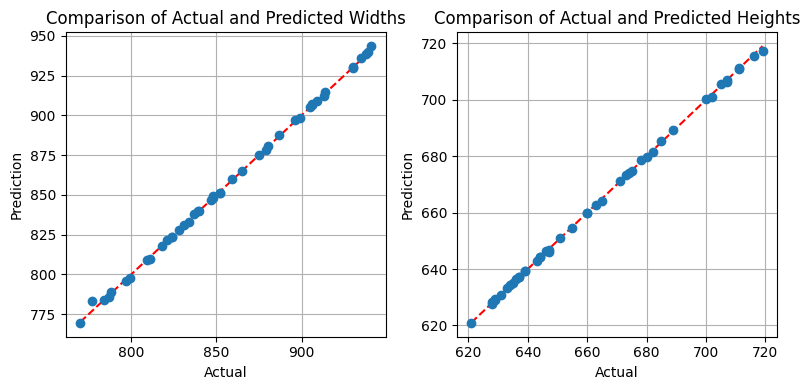

Absolute Error Metrics for Width:
Minimum Absolute Error (nm): 0.0044
Mean Absolute Error (nm): 0.8081
Maximum Absolute Error (nm): 6.4042

Absolute Error Metrics for Height:
Minimum Absolute Error (nm): 0.0414
Mean Absolute Error (nm): 0.3327
Maximum Absolute Error (nm): 1.5518



In [15]:
input_layer = tf.keras.Input(shape=(171,))

# Wide path (direct connections)
wide = Dense(64, activation='relu')(input_layer)

# Deep path
deep = Dense(128, activation='relu')(input_layer)
deep = Dense(128, activation='relu')(deep)
deep = Dense(64, activation='relu')(deep)

# Concatenate
merged = tf.keras.layers.concatenate([wide, deep])
output = Dense(2, activation='linear')(merged)

model = tf.keras.Model(inputs=input_layer, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mae'])

# Train with more epochs
history = model.fit(X_train_scaled, Y_train_scaled,
                    epochs=300,
                    batch_size=32,
                    validation_data=(X_test_scaled, Y_test_scaled),
                    callbacks=callbacks,
                    verbose=0)

# Predict on test data
y_pred_scaled = model.predict(X_test_scaled)

pred1 = y_pred_scaled[:,0]*(column_maxs[0]-column_means[0])+column_means[0]
pred2 = y_pred_scaled[:,1]*(column_maxs[1]-column_means[1])+column_means[1]

compare_results(y_actual, pred1, pred2)

In [16]:
def get_N_vs_errors(ind):
  N = len(ind)
  N1 = int(2 ** np.ceil(np.log2(N)))
  N2 = int(N1/2)
  N3 = int(N1/4)

  input_layer = tf.keras.Input(shape=(N,))

  # Wide path (direct connections)
  wide = Dense(N1, activation='relu')(input_layer)

  # Deep path
  deep = Dense(N1, activation='relu')(input_layer)
  deep = Dense(N1, activation='relu')(deep)
  deep = Dense(N2, activation='relu')(deep)
  deep = Dense(N3, activation='relu')(deep)

  # Concatenate
  merged = tf.keras.layers.concatenate([wide, deep])
  output = Dense(2, activation='linear')(merged)

  model = tf.keras.Model(inputs=input_layer, outputs=output)

  model.compile(optimizer=Adam(learning_rate=0.001),
                loss='mse',
                metrics=['mae'])

  # Callbacks
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=0)
  early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0)

  # Train the model
  history = model.fit(X_train_scaled[:,ind], Y_train_scaled,
                      epochs=300,
                      batch_size=32,
                      validation_data=(X_test_scaled[:,ind], Y_test_scaled),
                      callbacks=[reduce_lr, early_stop],
                      verbose=0)

  # Predict on test data
  y_pred_scaled = model.predict(X_test_scaled[:,ind])
  pred1 = y_pred_scaled[:,0]*(column_maxs[0]-column_means[0])+column_means[0]
  pred2 = y_pred_scaled[:,1]*(column_maxs[1]-column_means[1])+column_means[1]
  absolute_errors1 = np.abs(y_actual[:, 0] - pred1)
  absolute_errors2 = np.abs(y_actual[:, 1] - pred2)

  return (np.min(absolute_errors1), np.mean(absolute_errors1), np.max(absolute_errors1), np.min(absolute_errors2), np.mean(absolute_errors2), np.max(absolute_errors2))

In [17]:
no_trials = 20
no_regions = 3
Nmax = 171

# Dint_sample_range = np.arange(3, round((Nmax-2)/no_regions) + 1)
Dint_sample_range = np.array([5, 10, 15, 20, 25, 30, 40, 50])
error_val = np.zeros((len(Dint_sample_range), no_trials))

min_errors1 = np.zeros((len(Dint_sample_range),no_trials))
mean_errors1 = np.zeros((len(Dint_sample_range),no_trials))
max_errors1 = np.zeros((len(Dint_sample_range),no_trials))
min_errors2 = np.zeros((len(Dint_sample_range),no_trials))
mean_errors2 = np.zeros((len(Dint_sample_range),no_trials))
max_errors2 = np.zeros((len(Dint_sample_range),no_trials))

for irang in range(len(Dint_sample_range)):
    no_samples = Dint_sample_range[irang]  # choose an odd number

    for itx in range(no_trials):
        Dintsample = Nmax - 2
        ind_rand_samples = np.array([], dtype=int)  # Ensure integer type

        for irx in range(1, no_regions + 1):
            nmax = int(np.floor(Dintsample/no_regions))

            l1 = nmax * (irx - 1) + round(no_samples/2)
            l2 = nmax * irx - round(no_samples/2)

            if l1 < l2:
                rand_center = np.random.randint(l1, l2 + 1)
            else:
                rand_center = np.random.randint(l2, l1 + 1)

            # Create integer range and ensure proper bounds
            start = int(rand_center - np.floor(no_samples/2))
            end = int(rand_center + np.floor(no_samples/2))
            samples = np.arange(start, end + 1)

            ind_rand_samples = np.concatenate((ind_rand_samples, samples))

        # Filter and convert to integers
        ind_rand_samples = ind_rand_samples[(ind_rand_samples <= Dintsample) &
                                           (ind_rand_samples >= 1)].astype(int)
        mi1, me1, mx1, mi2, me2, mx2 = get_N_vs_errors(ind_rand_samples)
        min_errors1[irang, itx] = mi1
        mean_errors1[irang, itx] = me1
        max_errors1[irang, itx] = mx1
        min_errors2[irang, itx] = mi2
        mean_errors2[irang, itx] = me2
        max_errors2[irang, itx] = mx2
        print(mi1, me1, mx1, mi2, me2, mx2)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
0.027843713760375977 2.628790910271081 19.45978808403015 0.016119003295898438 1.5028249047357927 8.079626202583313
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
0.0573270320892334 3.5395344983447683 14.866368055343628 0.057929396629333496 1.7017134732820771 7.402169108390808
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
0.07700657844543457 3.643940435214476 19.959078311920166 0.016106843948364258 1.5486777070909739 7.145034492015839
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
0.07513797283172607 3.4802312078801068 17.99948024749756 0.048619866371154785 2.1290838058021935 10.25025749206543
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
0.0039386749267578125 3.6865953010591594 15.99276316165924 0.011844396591186523 2.7495798143473538 10.033135652542114
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
0.02244928479194641 4.0378009101206604 17.24924099445343 0.16706693172454834 2.67327587374232 6.721350401639938
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
0.05239272117614746 2.459890502420339 18

In [18]:
from google.colab import files

In [19]:
df = pd.DataFrame(min_errors1)
csv_file = 'min_errors1_data_SM1_200.csv'
df.to_csv(csv_file, index=False)
files.download(csv_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
df = pd.DataFrame(mean_errors1)
csv_file = 'mean_errors1_data_SM1_200.csv'
df.to_csv(csv_file, index=False)
files.download(csv_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
df = pd.DataFrame(max_errors1)
csv_file = 'max_errors1_data_SM1_200.csv'
df.to_csv(csv_file, index=False)
files.download(csv_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
df = pd.DataFrame(min_errors2)
csv_file = 'min_errors2_data_SM1_200.csv'
df.to_csv(csv_file, index=False)
files.download(csv_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
df = pd.DataFrame(mean_errors2)
csv_file = 'mean_errors2_data_SM1_200.csv'
df.to_csv(csv_file, index=False)
files.download(csv_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
df = pd.DataFrame(max_errors2)
csv_file = 'max_errors2_data_SM1_200.csv'
df.to_csv(csv_file, index=False)
files.download(csv_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

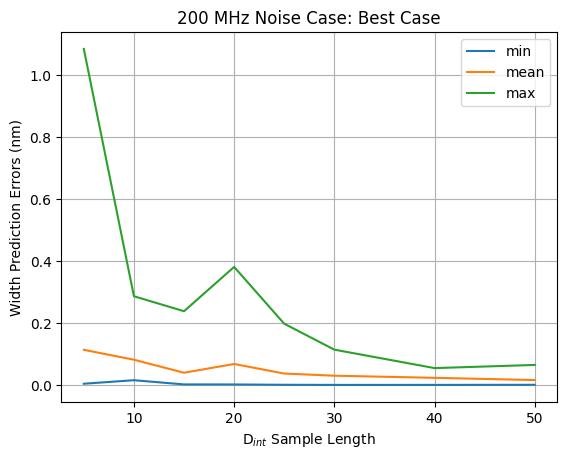

In [27]:
plt.plot(Dint_sample_range, np.min(min_errors1,axis=1),
         Dint_sample_range, np.mean(min_errors1,axis=1),
         Dint_sample_range, np.max(min_errors1,axis=1))
plt.legend(('min','mean','max'))
plt.grid()
plt.title('200 MHz Noise Case: Best Case')
plt.ylabel('Width Prediction Errors (nm)')
plt.xlabel('D$_{int}$ Sample Length')
plt.show()

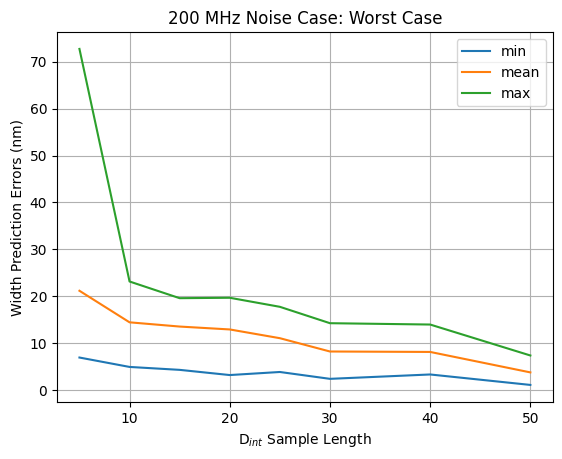

In [28]:
plt.plot(Dint_sample_range, np.min(max_errors1,axis=1),
         Dint_sample_range, np.mean(max_errors1,axis=1),
         Dint_sample_range, np.max(max_errors1,axis=1))
plt.legend(('min','mean','max'))
plt.grid()
plt.title('200 MHz Noise Case: Worst Case')
plt.ylabel('Width Prediction Errors (nm)')
plt.xlabel('D$_{int}$ Sample Length')
plt.show()